This first bit will be my SEIR graphical model

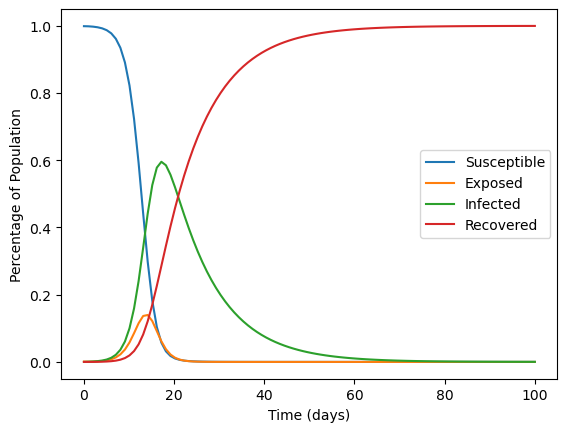

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.pyplot as plt

N = 7000000 #Initial population
S0 = 0.999 #Initial susceptible population percentage
E0 = 0.001 #Initial exposed population percentage
I0 = 0 #Initial infected population percentage
R0 = 0 #Initial recovered population percentage
 
# Implement ODE constants, where
# Beta = "Transmission rate"
# Sigma = "Incubation Rate"
# Gamma = "Recovery Rate?

def rhs(vec, t, Beta = 1, Sigma = 1, Gamma = 0.1):
    S = vec[0]
    E = vec[1]
    I = vec[2]
    R = vec[3]
    # Solution vector detailing needed variables (variables are percentage of N)
    
    f = np.zeros_like(vec)

    # dS/dt
    f[0] = -Beta*I*S

    # dE/dt
    f[1] = Beta*I*S - Sigma*E

    # dI/dt
    f[2] = Sigma*E-Gamma*I

    # dR/dt
    f[3] = Gamma*I
    
    return f

t = np.linspace(0,100,100)
vec0 = [S0, E0, I0, R0]
# Defining time array and initial value vector

soln = odeint(rhs, vec0, t)
S = soln[:,0]
E = soln[:,1]
I = soln[:,2]
R = soln[:,3]
# Solving ODE for solution vector

plt.plot(t, S, label = 'Susceptible')
plt.plot(t, E, label = 'Exposed')
plt.plot(t, I, label = 'Infected')
plt.plot(t, R, label = 'Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Percentage of Population')
plt.legend(loc=0)
# Plotting values





This next part details my entire "toy disease free-for-all" simulation

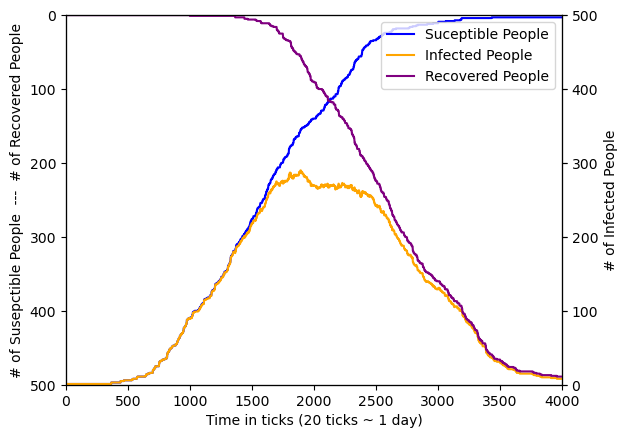

In [39]:
# Importing necessary libraries
import math
import numpy as np
import random
import pygame
import matplotlib.pyplot as plt
pygame.init()

# Creating widow that animation will play in
WIDTH = 1000
HEIGHT = 1000
WINDOW = pygame.display.set_mode((WIDTH, HEIGHT))

# Defining color dictionaries for easy access / modification
colorDefs = {"white": (255, 248, 240), 
                "blue": (0, 222, 255),
                 "orange": (255, 140, 0),
                 "pink": (247, 140, 237),
                "black": (0, 0, 0),
                "grey": (50, 50, 50)}

colors = {"background": colorDefs["grey"],
             "susceptible": colorDefs["white"],
             "infected": colorDefs["orange"],
             "recovered": colorDefs["blue"]}

#-------------------------------------------------------------------------------------------------------------------------------

# Defining a class for window "cells" to minimize distance calculation amount (will possibly regret doing this)
class Cell():
    def __init__(self, row, col):
        self.row = row
        self.col = col
        self.people = []
    
    # Gets index and info of all neighboring cells of any individual cell
    def get_neighboring_cells(self, n_rows, n_cols):
        index = self.row * n_cols + self.col
        N = index - n_cols if self.row > 0 else None
        S = index + n_cols if self.row < n_rows - 1 else None
        E = index + 1 if self.col < n_cols - 1 else None
        W = index - 1 if self.col > 0 else None
        NE = index - n_cols + 1 if self.row > 0 and self.col < n_cols - 1 else None
        NW = index - n_cols - 1 if self.row > 0 and self.col > 0 else None
        SE = index + n_cols + 1 if self.row < n_rows - 1 and self.col < n_cols - 1 else None
        SW = index + n_cols - 1 if self.row < n_rows - 1 and self.col > 0 else None
        return [i for i in [index, N, S, E, W, NW, NE, SW, SE] if i]

    
#-------------------------------------------------------------------------------------------------------------------------------  
    
    
# Defining a class for a "WINDOW"-sized grid made up of cells from our cell class
# This acts as a solution to relieve framerate from the infect_people() method by lowering the amount of "valid" target distance calculations (see "Line: 171 and 181" for insight)
# In other words, the grid changes the # of potentially-valid targets for each infected person to only those immediately around them instead of EVERY susceptible person in the window
# In hindsight, this entire grid/cell framework was a terrible idea, as it's the main reason I'm submitting late, 
# but hey, at least we can simulate 500 people smoothly instead of 50! (shown by fps counter)
# If you want to see what its like without the grid framework, and to see why the grid is pretty much necessary, see "Line: 205"
class Grid():
    def __init__(self, people, x_size = 50, y_size = 50):
        self.x_size = x_size
        self.y_size = y_size
        self.n_rows = HEIGHT // y_size
        self.n_cols = WIDTH // x_size
        self.cells = []
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                self.cells.append(Cell(row,col))
        self.store_people(people)
    
    # Defining function to store people in their respective cells
    def store_people(self, people):
        for p in people:
            row = int(p.y / self.y_size)
            col = int(p.x / self.x_size)
            index = row * self.n_cols + col
            self.cells[index].people.append(p)
            
    # Defining function to show the grid should we want to see it        
    def show(self, width = 1):
        for c in self.cells:
            x = c.col * self.x_size
            y = c.row * self.y_size
            rectangle = pygame.Rect(x, y, self.x_size, self.y_size)
            pygame.draw.rect(WINDOW, colorDefs["black"], rectangle, width = width)
        
    
#-------------------------------------------------------------------------------------------------------------------------------
    
    
# Defining our "Person" class
class Person():
    def __init__(self):
        self.x = random.uniform(0, WIDTH)
        self.y = random.uniform(0, HEIGHT)
        self.dx = 0
        self.dy = 0
        self.state = "susceptible"
        self.recovery_counter = 0
        
    # Function for displaying person on window   
    def show(self, size):
        pygame.draw.circle(WINDOW, colors[self.state], (self.x, self.y), size)
        
    # Function for deifining movement
    def move(self, speed = 0.005):
        
        # Change position vector
        self.x += self.dx 
        self.y += self.dy
        
        # Avoid any "out-of-bounds" movement
        if self.x >= WIDTH:
            self.x = WIDTH - 1
            self.dx = -self.dx
        if self.y >= HEIGHT:
            self.y = HEIGHT - 1
            self.dy = -self.dy
        if self.x <= 0:
            self.x = 1
            self.dx = -self.dx
        if self.y <= 0:
            self.y = 1
            self.dy = -self.dy
        
        # Change velocity vector
        self.dx += random.uniform(-speed, speed)
        if self.dx >= 0.6:
            self.dx = self.dx -.01
        if self.dx <= -0.6:
            self.dx = self.dx +.01
        self.dy += random.uniform(-speed, speed)
        if self.dy >= 0.6:
            self.dy = self.dy -.01
        if self.dy <= -0.6:
            self.dy = self.dy +.01
    
    # Function for infected people to infect others
    def get_infected(self, t_rec = 5000):
        self.state = "infected"
        self.recovery_counter = t_rec
        
    # Function for infected people to begin recovery   
    def recover(self) :
        self.recovery_counter -= 1
        if self.recovery_counter == 0:
            self.state = "recovered"
            
            
#-------------------------------------------------------------------------------------------------------------------------------            
            

# Defining overall epidemic "simulation" class where everything else will be neatly compiled and simulations can be ran with complete control over variables
# Doing this for compartmentalization, ease of testing, and ease of modification
# IMPORTANT: IF YOU DESIRE TO CHANGE ANY OF THE SIMULATION VARIABLES, PLEASE DO THEM HERE
class EpidemicSim():
    def __init__(self, N = 500, size = 5, speed = .02, infect_dist = 20, t_rec = 1000):
        self.N = N
        self.people = [Person() for i in range(N)]
        self.size = size
        self.speed = speed
        self.infect_dist = infect_dist
        self.t_rec = t_rec
        self.grid = Grid(self.people)
        self.people[0].get_infected(t_rec)
        self.data = []
        self.OVER = False
        self.timelength = 0
    
    # Updates the grid when called; re-indexes surrounding cells and re-stores people every call
    def update_grid(self):
        self.grid = Grid(self.people)
    
    # Obsolete, slow method for infecting others (NOT USED IN SIMULATION, KEPT FOR REFERENCE)
    def slowly_infect_people(self):
        for p in self.people:
            if p.state == "infected":
                for other in self.people:
                    if other.state == "susceptible":
                        distance = math.sqrt((p.x-other.x)**2+(p.y-other.y)**2)
                        if distance <= self.infect_dist:
                            other.get_infected()
                            
    # Frame-rate-friendly method for infecting others (USED IN SIMULATION)                      
    def infect_people(self):
        for c in self.grid.cells:
            
            # Do nothing if nobody is infected in that cell
            states = [p.state for p in c.people]
            if states.count("infected") == 0:
                continue
                
            # Create lists of ALL infected / non-infected people in the area
            people_in_area = []
            for index in c.get_neighboring_cells(self.grid.n_rows, self.grid.n_cols):
                people_in_area += self.grid.cells[index].people
                infected_people = [p for p in people_in_area if p.state == "infected"]
                susceptible_people = [p for p in people_in_area if p.state == "susceptible"]
                if len(susceptible_people) == 0:
                    continue
                    
            # Iterate through all infected people
                for i in infected_people:
                    for s in susceptible_people:
                        distance = math.sqrt((i.x-s.x)**2+(i.y-s.y)**2)
                        if distance <= self.infect_dist:
                            s.get_infected(self.t_rec)
    
    # Executes EpidemicSim() with given parameters
    # If you want to run the simulation without the grid system, replace "self.infect_people()" to "self.slowly_infect_people()" below
    def run(self):
        self.update_grid()
        self.infect_people()
        for p in self.people:
            if p.state == "infected":
                p.recover()
            p.move(self.speed)
            p.show(self.size)
                 
    # Records data point entailing the amount of people in each state at the time of being called 
    def track_data(self):
        states = [p.state for p in self.people]
        N_susceptible = states.count("susceptible")
        N_infected = states.count("infected")
        N_recovered = states.count("recovered")
        # New property to Pandemic() class - "data" - entails "N" of each state at time track_data() is called 
        self.data.append([N_susceptible, N_infected, N_recovered])
        if N_infected == 0:
            self.timelength = len(self.data)
            self.OVER = True
        
    # Create plots from data tracker, TIME ARRAY OF PLOT WILL GO TO TIME AT WHICH SIMULATION WINDOW IS CLOSED (EVEN IF ITS AFTER THE END OF THE EPIDEMIC)
    # DO NOT CLOSE THE SIMULATION BEFORE THE EPIDEMIC HAS RUN ITS COURSE, ANY REMAINING INFECTED PEOPLE WILL CAUSE ERROR WHEN CLOSING WINDOW
    def plot_summary(self):
        time_index = range(1, self.timelength + 1)
        susceptible = [i[0] for i in self.data]
        infected = [i[1] for i in self.data]
        recovered = [i[2] for i in self.data]
        
        # Initializing figure and first "inverted" axis for suscpetible people
        fig, ax_sus = plt.subplots()
        l1,=ax_sus.plot(time_index, susceptible, color = "blue",  label = "Suceptible People")
        ax_sus.set_ylabel("# of Susepctible People  ---  # of Recovered People", color = "black")
        ax_sus.set_xlabel("Time in ticks (20 ticks ~ 1 day)")
        ax_sus.set_xlim(0, 4000)
        ax_sus.set_ylim(self.N, 0)
        
        # Defining secondary "right side up" axis for infected people
        ax_inf = ax_sus.twinx() 
        l2,=ax_inf.plot(time_index, infected, color = "orange", label = "Infected People")
        ax_inf.set_ylabel("# of Infected People", color = "black")
        ax_inf.set_ylim(0, self.N)
        
        # Defining third "inverted" axis for recovered people
        ax_rec = ax_sus.twinx()
        l3,=ax_rec.plot(time_index, recovered, color = "purple", label = "Recovered People")
        ax_rec.set_ylim(self.N, 0)
        ax_rec.set_yticklabels([])
        plt.legend([l1, l2, l3], ["Suceptible People", "Infected People", "Recovered People"])
        plt.show()
        
            
# Everything before this point defines our epidemic simulation
#-------------------------------------------------------------------------------------------------------------------------------           
#-------------------------------------------------------------------------------------------------------------------------------           
#-------------------------------------------------------------------------------------------------------------------------------           
# Everything beyond this point is excecution code; "Activates" simulation                                    


# Creating a pandemic object from our class
epidemic = EpidemicSim()

# Pygame animation loop
clock = pygame.time.Clock()
font = pygame.font.SysFont("fontname", size = 30)
animating = True
while animating:
    
    # Setting the background color
    WINDOW.fill(colors["background"])
    
    # Run Pandemic
    epidemic.run()
    epidemic.track_data()
    
    # Updating the screen and the fps clock every tick
    clock.tick()
    clock_str = str(math.floor(clock.get_fps()))
    clock_text = font.render(clock_str, True, colorDefs["pink"], colors["background"])
    text_box = clock_text.get_rect(topleft = (10, 10))
    WINDOW.blit(clock_text, text_box) 
    pygame.display.flip()
    
    # Check for user interaction (end sequence)
    for event in pygame.event.get():
        
        # User closes pygame window
        if event.type == pygame.QUIT:
            animating = False
            epidemic.OVER = True
            pygame.quit()
        
        # Enables creation of useful keybinds
        if event.type == pygame.KEYDOWN:
            
            # "ESC" key now quits the currently running simulation
            if event.key == pygame.K_ESCAPE:
                animating = False
                epidemic.OVER = True
                pygame.quit()
            
            # "F" key now restarts the currently running simulation
            if event.key == pygame.K_f:
                epidemic = EpidemicSim()
                
# Create summary plot of epidemic simulation AFTER simulation has been run and exited        
epidemic.plot_summary()

# IMPORTANT NOTE: This graph's axes are a little unorthodox, as this is what Washington Post did with their simulation graphs
# The y-axis for infected people is regular, ranging from 0 to "N" people, while the y-axis for susceptible and recovered people is INVERTED, ranging from "N" to 0 people
# This change makes the graph look the way it's supposed to, otherwise it'd more resemble the graph created in the first part.